In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime
import category_encoders as ce

In [2]:
#Set parameter

dataset = 'train'

#Load data
data_ = pd.read_csv("data/" + dataset + ".csv")
data = data_.copy()

In [3]:
#First look
display(data.head(5))
data.shape

,ID,DATE_DEPARTURE_UTC,DATE_ARRIVAL_UTC,DATE_DEPARTURE_LCL,DATE_ARRIVAL_LCL,ORIGIN,ORIGIN_AIRPORT_ID,DEST,DEST_AIRPORT_ID,TAIL_NUM,OP_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,CANCELLED,DEP_DEL15,ARR_DEL15
0,345355,2020-01-18 22:10:00,2020-01-18 23:59:00,2020-01-18 15:10:00,2020-01-18 15:59:00,SLC,14869,SNA,14908,N128DU,DL,19790,1056,588.0,0,0.0,0
1,323447,2020-01-17 21:47:00,2020-01-18 04:10:00,2020-01-17 16:47:00,2020-01-17 20:10:00,BOS,10721,SEA,14747,N486AS,AS,19930,15,2496.0,0,NaN,0
2,242237,2020-01-13 13:26:00,2020-01-13 14:26:00,2020-01-13 07:26:00,2020-01-13 08:26:00,DAL,11259,HOU,12191,N901WN,WN,19393,3,239.0,0,NaN,0
3,271408,2020-01-15 02:45:00,2020-01-15 03:37:00,2020-01-14 20:45:00,2020-01-14 21:37:00,STL,15016,DSM,11423,N778SW,WN,19393,1588,259.0,0,0.0,0
4,282447,2020-01-15 23:22:00,2020-01-16 00:49:00,2020-01-15 18:22:00,2020-01-15 19:49:00,CLT,11057,CHS,10994,N579NN,OH,20397,5207,168.0,0,NaN,1


(419487, 17)

In [4]:
#Find columns with nulls values
null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum()

DISTANCE      17618
DEP_DEL15    146820
dtype: int64

In [5]:
data.count()

ID                       419487
DATE_DEPARTURE_UTC       419487
DATE_ARRIVAL_UTC         419487
DATE_DEPARTURE_LCL       419487
DATE_ARRIVAL_LCL         419487
ORIGIN                   419487
ORIGIN_AIRPORT_ID        419487
DEST                     419487
DEST_AIRPORT_ID          419487
TAIL_NUM                 419487
OP_CARRIER               419487
OP_CARRIER_AIRLINE_ID    419487
OP_CARRIER_FL_NUM        419487
DISTANCE                 401869
CANCELLED                419487
DEP_DEL15                272667
ARR_DEL15                419487
dtype: int64

In [6]:
#Analyze column Cancelled
data['CANCELLED'].value_counts()

0    419487
Name: CANCELLED, dtype: int64

In [7]:
#Identify columns to drop considering:
#Redundant columns - IDs vs Names, local and utc times
#Columns with same values (cancelled)
to_drop = ['DATE_DEPARTURE_LCL', 'DATE_ARRIVAL_LCL', 'CANCELLED', 'ORIGIN', 'DEST', 'OP_CARRIER']

In [8]:
df = data.drop(to_drop, axis=1)

In [9]:
df.dtypes

ID                         int64
DATE_DEPARTURE_UTC        object
DATE_ARRIVAL_UTC          object
ORIGIN_AIRPORT_ID          int64
DEST_AIRPORT_ID            int64
TAIL_NUM                  object
OP_CARRIER_AIRLINE_ID      int64
OP_CARRIER_FL_NUM          int64
DISTANCE                 float64
DEP_DEL15                float64
ARR_DEL15                  int64
dtype: object

In [10]:
#Set ID as Index
df = df.set_index('ID')

# Datetime special treatment

In [11]:
#Split the data Departure
df_date_sep = df.DATE_DEPARTURE_UTC.str.split(pat=' ', expand=True)
df_date_sep.columns = ['Date_Departure', 'Hours_Departure']
df_date_sep_hour = df_date_sep.Hours_Departure.str.split(pat=':', expand=True)
df_date_sep_hour.columns = ['hours','minute','second']


#Convert Departure Data to datetime
df_date_sep['Date_Departure'] = int(pd.to_datetime(df_date_sep['Date_Departure'])[0].strftime('%Y%m%d'))
df_date_sep['Hours_Departure'] = df['Hours_Departure']= df_date_sep_hour['hours'].values

#Add Departure data to df
df['Date_Departure']= df_date_sep['Date_Departure'].values
df['Hours_Departure'] = df_date_sep['Hours_Departure'].values

#Split the data Arrival
df_date_sep = df.DATE_ARRIVAL_UTC.str.split(pat=' ', expand=True)
df_date_sep.columns = ['Date_Arrival', 'Hours_Arrival']

#Convert Arrival Data to datetime
df_date_sep['Date_Arrival'] = int(pd.to_datetime(df_date_sep['Date_Arrival'])[0].strftime('%Y%m%d'))
df_date_sep['Hours_Arrival'] = df['Hours_Departure']= df_date_sep_hour['hours'].values


#Add arrival data to df
df['Date_Arrival']= df_date_sep['Date_Arrival'].values
df['Hours_Arrival']= df_date_sep['Hours_Arrival'].values

df = df.drop(['DATE_DEPARTURE_UTC','DATE_ARRIVAL_UTC'], axis =1)

# Numerical variabels

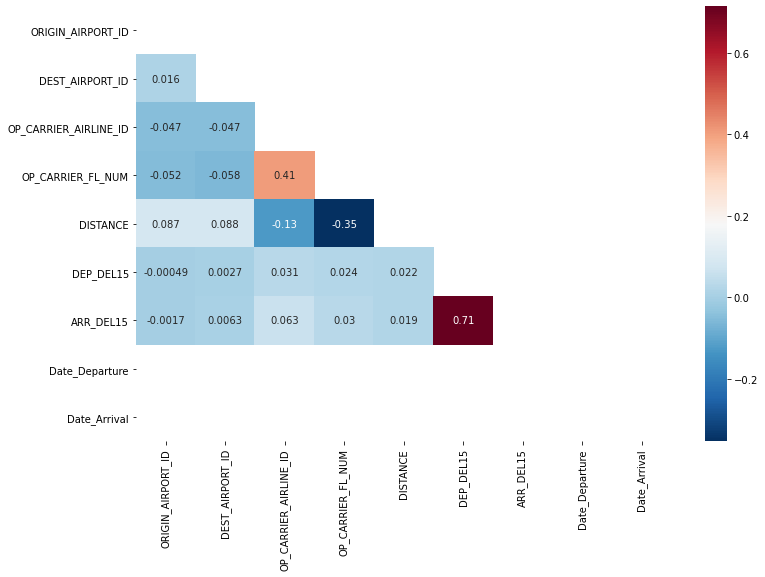

In [12]:
#check correlation
cor_df = df.corr()
lower_triangle_mask = np.triu(np.ones(cor_df.shape)).astype(np.bool)
cor_df_lower = cor_df.mask(lower_triangle_mask)
plt.figure(figsize = (12,8))
sns.heatmap(cor_df_lower, annot = True, cmap = "RdBu_r")

### Fill nulls

In [13]:
df['DEP_DEL15'] = df['DEP_DEL15'].fillna(0)

In [14]:
df['DEP_DEL15'].value_counts()

0.0    379343
1.0     40144
Name: DEP_DEL15, dtype: int64

In [15]:
#NICE TO HAVE
"""
"tailnums = df['TAIL_NUM'].unique()

for tn in tailnums:
    df.loc[df['TAIL_NUM'] == tn]['DISTANCE'].mean()
"""

'\n"tailnums = df[\'TAIL_NUM\'].unique()\n\nfor tn in tailnums:\n    df.loc[df[\'TAIL_NUM\'] == tn][\'DISTANCE\'].mean()\n'

In [16]:
mean = df['DISTANCE'].mean()
df['DISTANCE'] = df['DISTANCE'].fillna(mean)

In [17]:
#Check if there are no remaining nulls
df.count()

ORIGIN_AIRPORT_ID        419487
DEST_AIRPORT_ID          419487
TAIL_NUM                 419487
OP_CARRIER_AIRLINE_ID    419487
OP_CARRIER_FL_NUM        419487
DISTANCE                 419487
DEP_DEL15                419487
ARR_DEL15                419487
Hours_Departure          419487
Date_Departure           419487
Date_Arrival             419487
Hours_Arrival            419487
dtype: int64

# Categorical features

In [18]:
#Convert to category type
df = df.assign(TAIL_NUM=df['TAIL_NUM'].astype('category'))

In [19]:
df.dtypes

ORIGIN_AIRPORT_ID           int64
DEST_AIRPORT_ID             int64
TAIL_NUM                 category
OP_CARRIER_AIRLINE_ID       int64
OP_CARRIER_FL_NUM           int64
DISTANCE                  float64
DEP_DEL15                 float64
ARR_DEL15                   int64
Hours_Departure            object
Date_Departure              int64
Date_Arrival                int64
Hours_Arrival              object
dtype: object

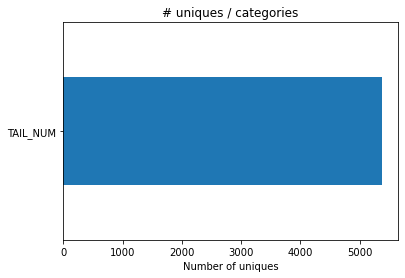

TAIL_NUM    5376
dtype: int64

In [20]:
#Check for unique values
categoricals = df.select_dtypes(include='category').columns
categoricals

number_of_uniques_per_category = df.loc[:, categoricals].nunique()

# little plot 
number_of_uniques_per_category.plot(kind='barh',
                                    title='# uniques / categories');
plt.xlabel('Number of uniques')
plt.show()


number_of_uniques_per_category

# Pipeline - scalling & encoding

## Scalling

In [21]:
df.dtypes

ORIGIN_AIRPORT_ID           int64
DEST_AIRPORT_ID             int64
TAIL_NUM                 category
OP_CARRIER_AIRLINE_ID       int64
OP_CARRIER_FL_NUM           int64
DISTANCE                  float64
DEP_DEL15                 float64
ARR_DEL15                   int64
Hours_Departure            object
Date_Departure              int64
Date_Arrival                int64
Hours_Arrival              object
dtype: object

In [22]:
numericals = df.select_dtypes(include=['int64','float64']).columns

In [23]:
df[numericals].describe()

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,DEP_DEL15,ARR_DEL15,Date_Departure,Date_Arrival
count,419487.000000,419487.000000,419487.000000,419487.000000,419487.000000,419487.000000,419487.000000,419487.0,419487.0
mean,12656.739730,12655.545597,19993.369749,2628.837404,803.586898,0.095698,0.148264,20200101.0,20200101.0
std,1525.037067,1524.512434,375.543815,1825.643818,577.367083,0.294177,0.355362,0.0,0.0
min,10135.000000,10135.000000,19393.000000,1.000000,31.000000,0.000000,0.000000,20200101.0,20200101.0
25%,11292.000000,11292.000000,19790.000000,1073.000000,386.000000,0.000000,0.000000,20200101.0,20200101.0
50%,12889.000000,12889.000000,19977.000000,2184.000000,675.000000,0.000000,0.000000,20200101.0,20200101.0
75%,14027.000000,14027.000000,20378.000000,4115.000000,1024.000000,0.000000,0.000000,20200101.0,20200101.0
max,16869.000000,16869.000000,20452.000000,6799.000000,5095.000000,1.000000,1.000000,20200101.0,20200101.0


In [24]:
##SCALE DE VARIAVEIS NUMERICAS

from sklearn.preprocessing import RobustScaler

#Features to scale

scale_list = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER_FL_NUM']


for f in scale_list:
    # initialize transformer with desired options
    robustscaler = RobustScaler()

    # save data to scale
    X_rbs = df[[f]]

    # fit transformer to data
    robustscaler.fit(X_rbs)

    # create new feature by transforming the data
    col_new_name = f + '_robust_scaled'
    df[f] = robustscaler.transform(X_rbs)


#drop original columns
df.drop(scale_list, axis = 1)
df

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,TAIL_NUM,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,DEP_DEL15,ARR_DEL15,Hours_Departure,Date_Departure,Date_Arrival,Hours_Arrival
ID,,,,,,,,,,,,
345355,0.723949,0.738208,N128DU,-0.318027,-0.370809,588.000000,0.0,0,22,20200101,20200101,22
323447,-0.792687,0.679342,N486AS,-0.079932,-0.713018,2496.000000,0.0,0,21,20200101,20200101,21
242237,-0.595978,-0.255210,N901WN,-0.993197,-0.716963,239.000000,0.0,0,13,20200101,20200101,13
271408,0.777697,-0.536015,N778SW,-0.993197,-0.195924,259.000000,0.0,0,02,20200101,20200101,02
282447,-0.669835,-0.692870,N579NN,0.714286,0.993754,168.000000,0.0,1,23,20200101,20200101,23
...,...,...,...,...,...,...,...,...,...,...,...,...
374775,0.366362,0.331627,N278WN,-0.993197,-0.233070,362.000000,0.0,0,00,20200101,20200101,00
295665,-0.435832,-0.150274,N2017J,0.734694,-0.322814,1069.000000,0.0,0,17,20200101,20200101,17
365119,-0.227788,0.000000,N832UA,0.000000,-0.374753,1222.000000,0.0,0,00,20200101,20200101,00


## Encoding

In [25]:
#ENCODING VARIAVEIS CATEGORICAS

encoder = ce.ordinal.OrdinalEncoder()

X2 = df[['TAIL_NUM']]
encoder.fit(X2)

df['TAIL_NUM_Encode'] = encoder.transform(X2)
df = df.drop('TAIL_NUM',axis=1)

In [26]:
## CRIAR PIPELINE
"""
# now let's make the pipeline
pipeline = make_pipeline(
    RemoveObjectColumns(),
    # it's cool how scikit already has a mean imputer ready to go!
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=10)
)

# No need for us to manually preprocess the X_train at all
pipeline.fit(X_train, y_train)

# Same thing for X_test
probas = pipeline.predict_proba(X_test)
"""

"\n# now let's make the pipeline\npipeline = make_pipeline(\n    RemoveObjectColumns(),\n    # it's cool how scikit already has a mean imputer ready to go!\n    SimpleImputer(strategy='mean'),\n    RandomForestClassifier(n_estimators=10)\n)\n\n# No need for us to manually preprocess the X_train at all\npipeline.fit(X_train, y_train)\n\n# Same thing for X_test\nprobas = pipeline.predict_proba(X_test)\n"

In [27]:
df.to_csv('data/' + dataset + '_worked.csv')